In [1]:
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc,accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import Imputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
hepatitis_data = pd.read_csv("dataset_55_hepatitis.csv")

In [4]:
replacements = {'no': 0,
               'yes': 1,
               'DIE': 0,
               'LIVE': 1,
               '?': np.nan,
               'female': 0,
               'male': 1}

hepatitis_data.replace(replacements, inplace = True)

In [5]:
hepatitis_data = hepatitis_data.astype(float)
hepatitis_data[['ALBUMIN', 'ALK_PHOSPHATE', 'BILIRUBIN', 'SGOT']] = hepatitis_data[['ALBUMIN','ALK_PHOSPHATE', 'BILIRUBIN', 'SGOT']].applymap(np.log)

In [6]:
hepatitis_data.isnull().sum() #shows how many nulls are there in each variable

AGE                 0
SEX                 0
STEROID             1
ANTIVIRALS          0
FATIGUE             1
MALAISE             1
ANOREXIA            1
LIVER_BIG          10
LIVER_FIRM         11
SPLEEN_PALPABLE     5
SPIDERS             5
ASCITES             5
VARICES             5
BILIRUBIN           6
ALK_PHOSPHATE      29
SGOT                4
ALBUMIN            16
PROTIME            67
HISTOLOGY           0
Class               0
dtype: int64

In [7]:
x = hepatitis_data.iloc[:,0:19] #x = hepatitis_data.iloc[:, hepatitis_data.columns != 'Class']
y = hepatitis_data.iloc[:,19] #y = hepatitis_data.iloc[:, hepatitis_data.columns == 'Class']

In [8]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=0)
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

In [9]:
imp = Imputer(missing_values = 'NaN', strategy = "most_frequent", axis = 0)
# replaces the missing values with the most frequent value in the column (axis = 0).
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
fit_random_forest = RandomForestClassifier(random_state = 42)
fit_random_forest.fit(X_train_imp, Y_train);

X_test_imp = imp.transform(X_test)
y_predicted = fit_random_forest.predict(X_test_imp)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
accuracy = accuracy_score(Y_test, y_predicted)*100
print(round(accuracy, 2), '%')

77.42 %


In [12]:
parameters_optimize = {
                      'max_features': ['auto', 'sqrt', 'log2', None], 
                      'max_depth': [2,3, 4],
                      'criterion': ['gini', 'entropy'],
                      'bootstrap': [True, False],
                      'n_estimators': [2, 5, 10, 15, 20]
                      } #Hyperparameters tuning

In [13]:
random_forest_hyp = RandomForestClassifier()

random_forest_search = GridSearchCV(random_forest_hyp,
                                   cv = 20,
                                   param_grid = parameters_optimize,
                                   n_jobs = 3)
random_forest_search.fit(X_train_imp, Y_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [2, 3, 4], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False], 'n_estimators': [2, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
print('The best parameteres after GridSearchCV', random_forest_search.best_params_)

The best parameteres after GridSearchCV {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}


In [15]:
random_forest_hyp.set_params(bootstrap = True, 
                            criterion = 'gini',
                            max_depth = 4,
                            max_features = 'auto',
                            n_estimators = 20)

random_forest_hyp.fit(X_train_imp, Y_train)

y_predicted_grid = random_forest_hyp.predict(X_test_imp)

In [16]:
accuracy_grid = accuracy_score(Y_test, y_predicted_grid)*100
print(round(accuracy_grid, 2), '%')

77.42 %


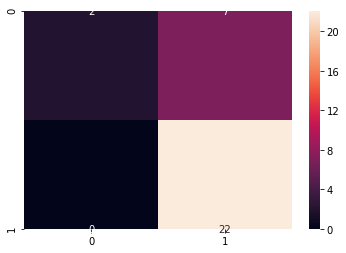

In [17]:
plt.figure()
random_confusion = confusion_matrix(Y_test, y_predicted_grid)
sns.heatmap(random_confusion, annot = True)

In [18]:
fpr, tpr, _= roc_curve(Y_test, y_predicted_grid)

auc_random_grid = auc(fpr, tpr)
print(auc_random_grid)

0.6111111111111112


Text(0, 0.5, 'True Positive rate')

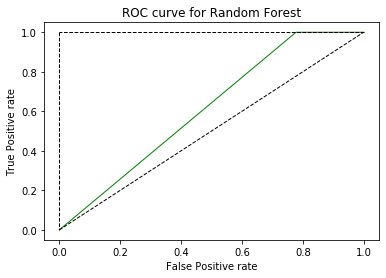

In [19]:
plt.figure()
plt.plot(fpr, tpr, color ='Green', linewidth = 1)
plt.title('ROC curve for Random Forest')
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')